In [1]:
#tensorflow==2.2.0
#tensorflow_hub=0.8.0
#sentencepiece==0.1.91
#tqdm==4.47.0
#seaborn==0.10.1
#numpy==1.19.0

In [2]:
import tensorflow as tf 
import tensorflow_hub as hub
import sentencepiece as spm
import six

from functools import wraps
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
def timethis(func):
   @wraps(func)
   def wrapper(*args, **kwargs):
       start = time.time()
       result = func(*args, **kwargs)
       end = time.time()
       print(func.__name__, end-start)
       return result
   return wrapper


In [4]:
# mkdir albert_en_base
# mkdir 1
# wget https://tfhub.dev/tensorflow/albert_en_base/1https://tfhub.dev/tensorflow/albert_en_base/1
# tar-xzf albert_en_base_1.tar.gztar-xzf albert_en_base_1.tar.gz
# rm -rf albert_en_base_1.tar.gzrm -rf albert_en_base_1.tar.gz
albert_layer = hub.KerasLayer("albert_en_base/1", trainable=False)

In [19]:
#Referred from https://github.com/tensorflow/models/blob/master/official/nlp/bert/tokenization.pyhttps://github.com/tensorflow/models/blob/master/official/nlp/bert/tokenization.py
def printable_text(text):
  """Returns text encoded in a way suitable for print or `tf.logging`."""
  if isinstance(text, str):
    return text
  elif isinstance(text, bytes):
    return text.decode("utf-8", "ignore")
  else:
    raise ValueError("Unsupported string type: %s" % (type(text)))

def encode_pieces(sp_model, text, sample=False):
  """Segements text into pieces.
  Args:
    sp_model: A spm.SentencePieceProcessor object.
    text: The input text to be segemented.
    sample: Whether to randomly sample a segmentation output or return a
      deterministic one.
  Returns:
    A list of token pieces.
  """
  if not sample:
    pieces = sp_model.EncodeAsPieces(text)
  else:
    pieces = sp_model.SampleEncodeAsPieces(text, 64, 0.1)
  new_pieces = []
  for piece in pieces:
    piece = printable_text(piece)
    if len(piece) > 1 and piece[-1] == "," and piece[-2].isdigit():
      cur_pieces = sp_model.EncodeAsPieces(piece[:-1].replace(
          SPIECE_UNDERLINE, ""))
      if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
        if len(cur_pieces[0]) == 1:
          cur_pieces = cur_pieces[1:]
        else:
          cur_pieces[0] = cur_pieces[0][1:]
      cur_pieces.append(piece[-1])
      new_pieces.extend(cur_pieces)
    else:
      new_pieces.append(piece)

  return new_pieces

In [20]:
@timethis
class FullSentencePieceTokenizer(object):
  """Runs end-to-end sentence piece tokenization.
  The interface of this class is intended to keep the same as above
  `FullTokenizer` class for easier usage.
  """

  def __init__(self, sp_model_file):
    """Inits FullSentencePieceTokenizer.
    Args:
      sp_model_file: The path to the sentence piece model file.
    """
    self.sp_model = spm.SentencePieceProcessor()
    self.sp_model.Load(sp_model_file)
    self.vocab = {
        self.sp_model.IdToPiece(i): i
        for i in six.moves.range(self.sp_model.GetPieceSize())
    }

  def tokenize(self, text):
    """Tokenizes text into pieces."""
    return encode_pieces(self.sp_model, text)

  def convert_tokens_to_ids(self, tokens):
    """Converts a list of tokens to a list of ids."""
    return [self.sp_model.PieceToId(printable_text(token)) for token in tokens]

  def convert_ids_to_tokens(self, ids):
    """Converts a list of ids ot a list of tokens."""
    return [self.sp_model.IdToPiece(id_) for id_ in ids]

In [21]:
def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [22]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

In [23]:
def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

In [13]:
sentence = "I am amazed"

In [10]:
sp_model_file = albert_layer.resolved_object.sp_model_file.asset_path.numpy()
tokenizer = FullSentencePieceTokenizer(sp_model_file)

FullSentencePieceTokenizer 0.12377095222473145


In [14]:
stokens = tokenizer.tokenize(sentence)

In [15]:
MAX_LEN = 20

In [16]:
stokens = stokens[:MAX_LEN]
stokens = ["[CLS]"] + stokens + ["[SEP]"]

In [17]:
stokens

['[CLS]', '▁', 'I', '▁am', '▁amazed', '[SEP]']

In [25]:
MAX_LEN = 20
MAX_SEQ_LEN= MAX_LEN + 2

In [26]:
ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
masks = get_masks(stokens, MAX_SEQ_LEN)
segments = get_segments(stokens, MAX_SEQ_LEN)

In [59]:
ids

[2, 13, 1, 589, 17378, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [60]:
masks

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [61]:
segments

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [70]:
#@timethis
def create_single_input(sentence, MAX_LEN, MAX_SEQ_LEN):
    stokens = tokenizer.tokenize(sentence)
    stokens = stokens[:MAX_LEN]
    stokens = ["[CLS]"] + stokens + ["[SEP]"]

    ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
    masks = get_masks(stokens, MAX_SEQ_LEN)
    segments = get_segments(stokens, MAX_SEQ_LEN)

    return ids,masks,segments

In [28]:
stokens = tokenizer.tokenize("the body is made of metallica and deliveri high tension")
stokens

['▁the',
 '▁body',
 '▁is',
 '▁made',
 '▁of',
 '▁metallic',
 'a',
 '▁and',
 '▁deliver',
 'i',
 '▁high',
 '▁tension']

In [43]:
max_seq_length = MAX_SEQ_LEN

In [44]:
@timethis
def get_model():
    input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                       name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                   name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                    name="segment_ids")
    pooled_output, sequence_output = albert_layer([input_word_ids, input_mask, segment_ids])
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])
    return model


In [45]:
albert_model = get_model()

get_model 0.02585434913635254


In [46]:
albert_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 22)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 22)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 22)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 11683584    input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [47]:
768

768

In [54]:
s = "This is a nice sentence."
def get_albert_vec(s):
    stokens = tokenizer.tokenize(s)
    stokens = ["[CLS]"] + stokens + ["[SEP]"]
    ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
    masks = get_masks(stokens, MAX_SEQ_LEN)
    segments = get_segments(stokens, MAX_SEQ_LEN)
    input_ids = np.asarray(ids, dtype=np.int32).reshape(1,22)
    input_masks = np.asarray(masks, dtype=np.int32).reshape(1,22)
    input_segments = np.asarray(segments, dtype=np.int32).reshape(1,22)
    return input_ids, input_masks, input_segments
input_ids, input_masks, input_segments = get_albert_vec(s)

In [55]:
%%time
pool_embs, word_embs = albert_model.predict(
    [[input_ids, input_masks, input_segments]]
)
pool_embs.shape

CPU times: user 496 ms, sys: 6.11 ms, total: 502 ms
Wall time: 165 ms


(1, 768)

In [56]:
word_embs.shape

(1, 22, 768)

In [71]:
#@timethis
def create_input_array(sentences):
    input_ids, input_masks, input_segments = [], [], []

    for sentence in tqdm(sentences,position=0, leave=True):
        ids,masks,segments=create_single_input(sentence,MAX_LEN, MAX_SEQ_LEN)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)

    return [tf.constant(input_ids, dtype=np.int32), 
            tf.constant(input_masks, dtype=np.int32), 
            tf.constant(input_segments, dtype=np.int32)]

In [72]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  print(corr)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0.5,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  tmp_ip = create_input_array(messages_)
  message_embeddings_, _  = albert_model.predict(tmp_ip)
  message_embeddings_  = tf.nn.l2_normalize(message_embeddings_, axis=1)
  plot_similarity(messages_, message_embeddings_, 90)

100%|██████████| 6/6 [00:00<00:00, 7793.69it/s]
[[0.9999999  0.9238588  0.8991361  0.7740376  0.91989684 0.6788115 ]
 [0.9238588  0.99999976 0.9521425  0.7492999  0.986135   0.64105654]
 [0.8991361  0.9521425  0.99999994 0.84353626 0.94950557 0.7046951 ]
 [0.7740376  0.7492999  0.84353626 1.0000001  0.7775355  0.8934795 ]
 [0.91989684 0.986135   0.94950557 0.7775355  1.0000001  0.68906575]
 [0.6788115  0.64105654 0.7046951  0.8934795  0.68906575 1.0000002 ]]


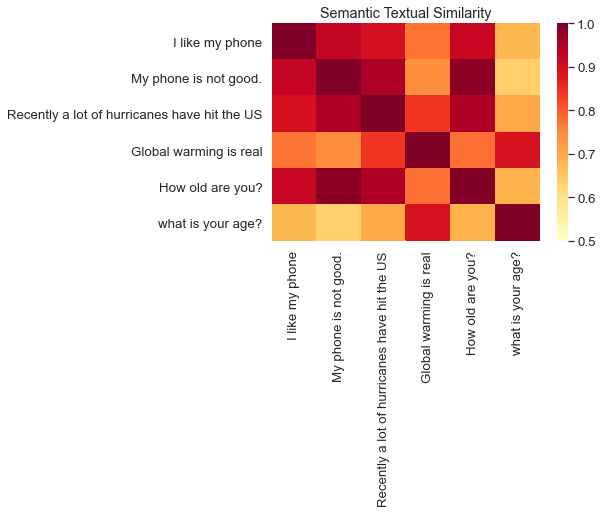

In [73]:
sentences = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    
    # Weather
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",
    
    # Asking about age
    "How old are you?",
    "what is your age?",
]
run_and_plot(sentences)

In [86]:
%%time
ip = create_input_array(sentences)

100%|██████████| 6/6 [00:00<00:00, 1863.44it/s]create_single_input 0.00011157989501953125
create_single_input 8.392333984375e-05
create_single_input 6.699562072753906e-05
create_single_input 9.34600830078125e-05
create_single_input 6.031990051269531e-05
create_single_input 4.553794860839844e-05
create_input_array 0.006663084030151367
CPU times: user 8.52 ms, sys: 39 µs, total: 8.56 ms
Wall time: 6.86 ms



In [87]:
%%time
pool_embs, all_embs = albert_model.predict(
    ip
)

CPU times: user 1.39 s, sys: 39.9 ms, total: 1.43 s
Wall time: 352 ms


In [88]:
sentences

['My phone is not good.',
 'Your cellphone looks great.',
 'Will it snow tomorrow?',
 'Recently a lot of hurricanes have hit the US',
 'An apple a day, keeps the doctors away',
 'Eating strawberries is healthy']

In [89]:
normalized_embedding  = tf.nn.l2_normalize(pool_embs, axis=1)

In [94]:
np.inner(normalized_embedding, normalized_embedding)

array([[0.99999976, 0.9964543 , 0.9294615 , 0.9521425 , 0.85180426,
        0.5512831 ],
       [0.9964543 , 0.9999999 , 0.92824733, 0.9553985 , 0.8503684 ,
        0.56159157],
       [0.9294615 , 0.92824733, 0.99999964, 0.92798823, 0.9475097 ,
        0.7530533 ],
       [0.9521425 , 0.9553985 , 0.92798823, 0.99999994, 0.88712585,
        0.65153885],
       [0.85180426, 0.8503684 , 0.9475097 , 0.88712585, 1.        ,
        0.86957175],
       [0.5512831 , 0.56159157, 0.7530533 , 0.65153885, 0.86957175,
        1.0000001 ]], dtype=float32)

In [78]:
normalized_embedding.shape

TensorShape([6, 768])

In [79]:
np.inner(normalized_embedding, normalized_embedding)

array([[0.99999976, 0.9964543 , 0.9294615 , 0.9521425 , 0.85180426,
        0.5512831 ],
       [0.9964543 , 0.9999999 , 0.92824733, 0.9553985 , 0.8503684 ,
        0.56159157],
       [0.9294615 , 0.92824733, 0.99999964, 0.92798823, 0.9475097 ,
        0.7530533 ],
       [0.9521425 , 0.9553985 , 0.92798823, 0.99999994, 0.88712585,
        0.65153885],
       [0.85180426, 0.8503684 , 0.9475097 , 0.88712585, 1.        ,
        0.86957175],
       [0.5512831 , 0.56159157, 0.7530533 , 0.65153885, 0.86957175,
        1.0000001 ]], dtype=float32)

In [48]:
sim_mat = np.inner(normalized_embedding, normalized_embedding)